In [1]:
!pip install modAL

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import csv
import time
import pickle
import pandas as pd
import numpy as np
from functools import partial
import seaborn as sn


import tensorflow as tf
from tensorflow import keras

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.base import BaseEstimator

from modAL.models import ActiveLearner
from modAL.uncertainty import *
from modAL.batch import uncertainty_batch_sampling


import matplotlib.pyplot as plt
%matplotlib inline

import warnings

In [3]:
filePathName = './RandomForest.pkl'
loaded_model = pickle.load(open(filePathName, 'rb'))

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.22.2.post1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [4]:
useStats = 1
useAttributeName = 1
useSample1 = 0
useSample2 = 0
## Using descriptive stats and attribute name

In [5]:
dict_label = {
    'numeric': 0,
    'categorical': 1,
    'datetime': 2,
    'sentence': 3,
    'url': 4,
    'embedded-number': 5,
    'list': 6,
    'not-generalizable': 7,
    'context-specific': 8
}

dict_label_list = [k for k,v in sorted(dict_label.items(), key = lambda x: x[1])]
print(dict_label_list)

['numeric', 'categorical', 'datetime', 'sentence', 'url', 'embedded-number', 'list', 'not-generalizable', 'context-specific']


In [6]:
def ProcessStats(data,y):

    data1 = data[['total_vals', 'num_nans', '%_nans', 'num_of_dist_val', '%_dist_val', 'mean', 'std_dev', 'min_val', 'max_val','has_delimiters', 'has_url', 'has_email', 'has_date', 'mean_word_count',
       'std_dev_word_count', 'mean_stopword_total', 'stdev_stopword_total',
       'mean_char_count', 'stdev_char_count', 'mean_whitespace_count',
       'stdev_whitespace_count', 'mean_delim_count', 'stdev_delim_count',
       'is_list', 'is_long_sentence']]
    data1 = data1.reset_index(drop=True)
    data1 = data1.fillna(0)

    y.y_act = y.y_act.astype(float)
    
    return data1

vectorizerName = CountVectorizer(ngram_range=(2, 2), analyzer='char')
vectorizerSample = CountVectorizer(ngram_range=(2, 2), analyzer='char')

def FeatureExtraction(data,data1,flag):

    arr = data['Attribute_name'].values
    arr = [str(x) for x in arr]
    
    arr1 = data['sample_1'].values
    arr1 = [str(x) for x in arr1]
    arr2 = data['sample_2'].values
    arr2 = [str(x) for x in arr2]
    arr3 = data['sample_3'].values
    arr3 = [str(x) for x in arr3]    
    #print(len(arr1),len(arr2))
    if flag:
        X = vectorizerName.fit_transform(arr)
        X1 = vectorizerSample.fit_transform(arr1)
        X2 = vectorizerSample.transform(arr2)   
    else:
        X = vectorizerName.transform(arr)
        X1 = vectorizerSample.transform(arr1)
        X2 = vectorizerSample.transform(arr2)        
        
#     print(f"> Length of vectorized feature_names: {len(vectorizer.get_feature_names())}")

    attr_df = pd.DataFrame(X.toarray())
    sample1_df = pd.DataFrame(X1.toarray())
    sample2_df = pd.DataFrame(X2.toarray())
    #print(len(data1),len(attr_df),len(sample1_df),len(sample2_df))

    if useSample1: data2 = sample1_df
    if useSample2: data2 = sample2_df    
    
    data2 = pd.concat([data1, attr_df], axis=1, sort=False)
    #print(len(data2))
    return data2



In [7]:
def get_data(sim_size = 0.8):
    """
    sim_size is the % of training data that goes into simulation set.
    """
    xtrain = pd.read_csv('./data_train.csv')
    xtest = pd.read_csv('./data_test.csv')

    y_train = xtrain.loc[:,['y_act']]
    y_test = xtest.loc[:,['y_act']]
    y_train['y_act'] = [dict_label[i] for i in y_train['y_act']]
    y_test['y_act'] = [dict_label[i] for i in y_test['y_act']]
    
    xtrain1 = ProcessStats(xtrain,y_train)
    xtest1 = ProcessStats(xtest,y_test)


    X_train = FeatureExtraction(xtrain,xtrain1,1)
    X_test = FeatureExtraction(xtest,xtest1,0)


    X_train_new = X_train.reset_index(drop=True)
    y_train_new = y_train.reset_index(drop=True)
    X_train_new = X_train_new.values
    y_train_new = y_train_new.values
    
    # setting up data
    X_train_AL, X_simulation_AL, y_train_AL, y_simulation_AL = train_test_split(X_train_new, y_train, test_size=sim_size, random_state=4)
    # Start AL loops simulated with a part of the test data
    X_simulation_df = pd.DataFrame(X_simulation_AL)
    y_simulation_df = pd.DataFrame(y_simulation_AL)
    # making copies of existing X_test and y_test data
    X_test_AL = pd.DataFrame(X_test)
    y_test_AL = pd.DataFrame(y_test)
    
    assert len(X_train_AL) == len(y_train_AL)
    assert len(X_simulation_df) == len(y_simulation_df)
    assert len(X_test_AL) == len(y_test_AL)
    return X_train_AL, y_train_AL, X_simulation_df, y_simulation_df, X_test_AL, y_test_AL

X_train, y_train, X_sim, y_sim, X_test, y_test = get_data()
print(f"Training set size: {len(X_train)}, Simulation set size: {len(X_sim)}, Test set size: {len(X_test)}")


Training set size: 1587, Simulation set size: 6349, Test set size: 1985


In [8]:
print(X_train.shape, y_train.shape)
print(X_sim.shape, y_sim.shape)
print(X_test.shape, y_test.shape)

(1587, 1478) (1587, 1)
(6349, 1478) (6349, 1)
(1985, 1478) (1985, 1)


In [9]:
def grid_parameter_search(X_train, y_train, X_test, y_test, n_estimators_grid, max_depth_grid, query_size):
    best_model_score = 0
    
    preset_batch = partial(uncertainty_sampling, n_instances=query_size)
    
    for ne in n_estimators_grid:
        for md in max_depth_grid:
            learner = ActiveLearner(
                  estimator=RandomForestClassifier(n_estimators=ne, max_depth=md, random_state=100),
                  X_training=X_train, y_training=y_train,
                  query_strategy=preset_batch
                )
            score = learner.score(X_test, y_test)
            print(f"[n_estimator: {ne}, max_depth: {md}, accuracy: {score}]")
            if best_model_score < score:
                best_ne = ne
                best_md = md
                best_model_score = score
                bestPerformingModel = learner
    print(f"best model found at ne:{best_ne}, md:{best_md}, at score:{best_model_score}")
    return learner, best_ne, best_md, best_model_score


#learner, best_ne, best_md, best_model_score = grid_parameter_search(X_train, y_train, X_sim, y_sim, [i*100 for i in range(1,11)],[i*100 for i in range(11)], 100)
#print(f"[BEST OBTAINED RF ESTIMATOR] === [n_estimator: {best_ne}, max_depth: {best_md}, accuracy: {best_model_score}]")

In [10]:
def save_his(data, full_path):
    assert data != None and len(data.items()) > 0, "data should not be empty"
    
    with open(full_path, "w") as outfile:
        writer = csv.writer(outfile)
        writer.writerow(list(data.keys()))
        writer.writerows(zip(*data.values()))
    

test_data_1 = [i for i in range(100)]
test_data_2 = [i*2 for i in range(100)]
test_data_3 = [i*3 for i in range(100)]
test_data_4 = [i*4 for i in range(100)]
data = {"num_queries": test_data_1, "time": test_data_2, "total_time":test_data_3, "test_accuracy":test_data_4}

save_his(data, "./his/test.csv")

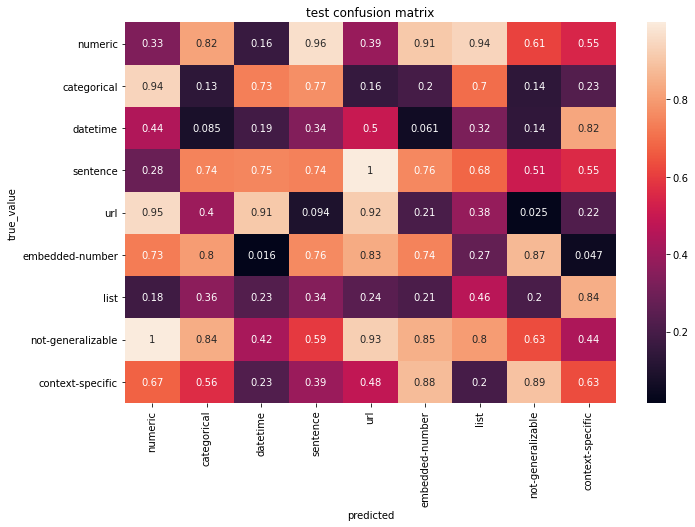

In [11]:
con_matrix = np.random.rand(9,9)
title = "test confusion matrix"
img_folder = "./img"

def save_con_matrix(con_matrix, title, full_path, show=False):
    plt.figure(figsize = (11,7))
    df_cm = pd.DataFrame(con_matrix, index = dict_label_list, columns = dict_label_list)
    sn.heatmap(con_matrix, annot=True, xticklabels=dict_label_list, yticklabels=dict_label_list, ) # font size

    plt.title(title) # title with fontsize 20
    plt.xlabel('predicted') # x-axis label with fontsize 15
    plt.ylabel('true_value') # y-axis label with fontsize 15

    plt.savefig(full_path)

save_con_matrix(con_matrix, title, img_folder + "/test_matrix.png")

In [12]:
feed_his_folder = "./feed"

test_feed = np.random.rand(9,9)

def save_feed(feed, full_path):
    file = open(full_path, 'wb')
    pickle.dump(feed, file)
    
def load_feed(full_path):
    file = open(full_path, 'rb')
    return pickle.load(file)

save_feed(test_feed, feed_his_folder+"/test.pkl")
re = load_feed(feed_his_folder+"/test.pkl")

assert np.all(test_feed == re)

In [13]:
his_folder = "./his"
img_folder = "./img"
feed_folder = "./feed"

def train_this(n_est, max_dept, query_size, max_feed, per_iteration_acc_report = True):
    
    # getting data
    X_train, y_train, X_sim, y_sim, X_test, y_test = get_data()
    
    # get learner
    preset_batch = partial(uncertainty_batch_sampling, n_instances=query_size)
    learner = ActiveLearner(\
    estimator=RandomForestClassifier(n_estimators=n_est, max_depth=max_dept, random_state=100),
        X_training=X_train, y_training=y_train,
        query_strategy=preset_batch
        )
    
    # init tracker lists
    num_queries = []
    time_history = []
    total_time_history = []
    train_acc_history = [learner.score(X_train, y_train)]
    sim_acc_history = [learner.score(X_sim, y_sim)]
    test_acc_history = [learner.score(X_test, y_test)]
    feed_to_learner = []
    
    print(f"learner trained_acc:{train_acc_history}, sim_acc:{sim_acc_history}, test_acc:{test_acc_history}")
    
    # AL cycle
    t_start = time.time()
    num_of_queries = int(len(X_sim)/query_size) + 1
    
    num_of_queries = 2 #temp, remove for actual runs
    while len(feed_to_learner) * query_size < max_feed :
        current_count = len(feed_to_learner) * query_size
        print(f"\n*********** QUERY {current_count} *********** remain:{len(X_sim)}")
        t0 = time.time()
        
        #AL selection
        query_idx, query_inst = learner.query(np.array(X_sim))
        if current_count + len(query_idx) > max_feed:
            query_idx = query_idx[:current_count + len(query_idx) - max_feed]
            query_inst = query_inst[:current_count + len(query_idx) - max_feed] 
        print(f"Nodes returned for query in query {current_count}: {query_idx}")

        #updating learner
        learner.teach(X = X_sim.iloc[query_idx], y = y_sim.iloc[query_idx])
        feed_to_learner.append(list(query_idx))
        
        X_sim = X_sim.drop(X_sim.index[query_idx])
        y_sim = y_sim.drop(y_sim.index[query_idx])

        #df version
        # delete queries that have been looped back into the model
        #X_simulation_df = X_simulation_df.drop(X_simulation_df.index[query_idx])
        #y_simulation_df = y_simulation_df.drop(y_simulation_df.index[query_idx])

        #np version
        # learner.teach(X = pd.Series(X_simulation_np[idx]), y = y_simulation_np[idx])
        # X_simulation_np = np.delete(X_simulation_np, query_index, axis=0)
        # y_simulation_np = np.delete(y_simulation_np, query_index)
        
        # recording history
        t1 = time.time()
        time_history.append(t1 - t0)
        total_time_history.append(t1 - t_start)
        num_queries.append(len(feed_to_learner))

        # Calculate and report our model's accuracy.
        if per_iteration_acc_report:
            test_acc = learner.score(X_test, y_test)
            sim_acc = learner.score(X_sim, y_sim)
            #train_acc = learner.score(X_train, y_train)
                
            test_acc_history.append(  test_acc  )
            sim_acc_history.append(   sim_acc   )
            #train_acc_history.append( train_acc )
            print(f"\n[INTERMEDIATE] test_acc:{test_acc}, sim_acc:{sim_acc}")
            
        print(f"\n[INTERMEDIATE] Time taken for query {current_count}: {time_history[-1]}")
        print(f"\n[INTERMEDIATE] Total time taken {current_count}: {total_time_history[-1]}")

    # saving data into csv
    print("saving data")
    
    al_sampling = "Uncertainty_Batch_Sampling"
    file_name = f"{al_sampling}_ne{n_est}_dept{max_dept}_query{query_size}"
    
    data = {"num_queries": num_queries, "time": time_history, "total_time":total_time_history,\
            "train_accuracy":train_acc_history, "simulation_accuracy":sim_acc_history,\
            "test_accuracy":test_acc_history}
    save_his(data, f"{his_folder}/{file_name}.csv")
    
    # saving confusion matrix
    y_pred = learner.predict(X_test)
    con_matrix = confusion_matrix(y_test, y_pred)
    title = f"AL using decision tree classifier (n_est = {n_est}, max_dept = {max_dept}) with {al_sampling} (query_size = {query_size})"
    save_con_matrix(con_matrix, title, f"{img_folder}/{file_name}.png")
    
    # saving feed into pickle
    save_feed(feed_to_learner, f"{feed_folder}/{file_name}.pkl")
        
    print("completed")
    
#train_this(n_est=400, max_dept=100, query_size=10)

/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)


learner trained_acc:[1.0], sim_acc:[0.8965191368719483], test_acc:[0.8866498740554156]

*********** QUERY 0 *********** remain:6349
Nodes returned for query in query 0: [3477 3924 1288 4036 5130  894 6165  181 4038 3314 2780 2289 1028  396
 3863 5739  865 3165 2647 3999 5847 5323 5856 6069 4853 1520 1895 5384
 5245 5097 5941 3290 2985 3648 6088 4289  757 5970 3466  830 3959 2723
 4238 2181 5772 2808 2550 6344  126 3651 4703 3753  354  832 2315 5106
 4722 5398  149 6181 3951 5347 4433 3871 3246 2351  177  389 2405 5533
 1560 4557 3326 4295 1309 1947  530 3817 3639  775 2655 3746 4403 1998
 4392  573 2139 2064 2856 6048 3800   50 4699 3559 5329  164 2365 2358
 1041 5406 1740 4651  750 5169  702 2387   14 5604 2675 4620 4575 2882
 3869 6343 4864 4712 3281 4285 3462 2449  852  238  578 5432 1196 4653
 4075 2716 6283 2994 6274 3759 5959 4090 3336 3812 4906 1355 5986 1172
 4294 5927 5313 2477 6005 5727  206 3563 3331 4773 3585 3316 2834 3212
 1853  683 3257 4535 3018 1994 3454  242  900 3771

/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9324937027707808, sim_acc:0.9659749485885212

[INTERMEDIATE] Time taken for query 0: 6456.3906581401825

[INTERMEDIATE] Total time taken 0: 6456.390679836273
saving data
completed


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)


learner trained_acc:[1.0], sim_acc:[0.8965191368719483], test_acc:[0.8866498740554156]

*********** QUERY 0 *********** remain:6349
Nodes returned for query in query 0: [3477 3924 1288 4036 5130  894 6165  181 4038 3314]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.890176322418136, sim_acc:0.8995109638744282

[INTERMEDIATE] Time taken for query 0: 68.165611743927

[INTERMEDIATE] Total time taken 0: 68.16563725471497

*********** QUERY 10 *********** remain:6339
Nodes returned for query in query 10: [5314 5089 5730 2777 2286 3162  395 5847 3953 3993]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.889168765743073, sim_acc:0.8998261968715436

[INTERMEDIATE] Time taken for query 10: 64.94909882545471

[INTERMEDIATE] Total time taken 10: 134.30090236663818

*********** QUERY 20 *********** remain:6329
Nodes returned for query in query 20: [3854 1516 3862 1025 2642 6069 3639 4689 4224 3283]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.889168765743073, sim_acc:0.9033074853616079

[INTERMEDIATE] Time taken for query 20: 61.689451456069946

[INTERMEDIATE] Total time taken 20: 197.14946746826172

*********** QUERY 30 *********** remain:6319
Nodes returned for query in query 30: [6041 6020 5820 4830 3454 3739 3314 2398 2647 3934]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.891183879093199, sim_acc:0.9045807576478048

[INTERMEDIATE] Time taken for query 30: 71.25246024131775

[INTERMEDIATE] Total time taken 30: 272.75300765037537

*********** QUERY 40 *********** remain:6309
Nodes returned for query in query 40: [4261 5351   50 3707 3622  177 5500 5213 5365 4364]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8926952141057934, sim_acc:0.9060168280679473

[INTERMEDIATE] Time taken for query 40: 67.12460827827454

[INTERMEDIATE] Total time taken 40: 341.0750048160553

*********** QUERY 50 *********** remain:6299
Nodes returned for query in query 50: [2972 1732 6294 6224 2173 2439  148  753 2144 4262]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8952141057934508, sim_acc:0.9076164732071872

[INTERMEDIATE] Time taken for query 50: 79.48663425445557

[INTERMEDIATE] Total time taken 50: 421.8326952457428

*********** QUERY 60 *********** remain:6289
Nodes returned for query in query 60: [2534 3520  859 6284  404 6123  238 4018 1936 1884]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8942065491183879, sim_acc:0.9084249084249084

[INTERMEDIATE] Time taken for query 60: 72.87698101997375

[INTERMEDIATE] Total time taken 60: 495.87554121017456

*********** QUERY 70 *********** remain:6279
Nodes returned for query in query 70: [2332 3287 1446 4661  767 3765 3931 1217 5712 1427]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8967254408060453, sim_acc:0.9089168926463551

[INTERMEDIATE] Time taken for query 70: 76.37976956367493

[INTERMEDIATE] Total time taken 70: 573.415643453598

*********** QUERY 80 *********** remain:6269
Nodes returned for query in query 80: [ 125 2765 5044 4371 2292 2826 1543 3773 3533 2952]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.8967254408060453, sim_acc:0.9121265377855887

[INTERMEDIATE] Time taken for query 80: 72.27012085914612

[INTERMEDIATE] Total time taken 80: 646.8113725185394

*********** QUERY 90 *********** remain:6259
Nodes returned for query in query 90: [1223 4468   14 2800 2338 3981 4508 5483 5329 3423]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9022670025188917, sim_acc:0.914066250600096

[INTERMEDIATE] Time taken for query 90: 79.93581628799438

[INTERMEDIATE] Total time taken 90: 727.9430537223816

*********** QUERY 100 *********** remain:6249
Nodes returned for query in query 100: [1693 2688 5589 1737 4912 2918 5758  674 4786 5246]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9002518891687658, sim_acc:0.9164930277288027

[INTERMEDIATE] Time taken for query 100: 79.78745293617249

[INTERMEDIATE] Total time taken 100: 809.1304340362549

*********** QUERY 110 *********** remain:6239
Nodes returned for query in query 110: [1971 4439 6122 5885  569 4467 3531  740 3234  347]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9017632241813602, sim_acc:0.9173222026007385

[INTERMEDIATE] Time taken for query 110: 72.67120385169983

[INTERMEDIATE] Total time taken 110: 882.9649975299835

*********** QUERY 120 *********** remain:6229
Nodes returned for query in query 120: [3587  735 1454 6188 5415 5871 5005 1312 1436  426]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9032745591939546, sim_acc:0.9181540440585303

[INTERMEDIATE] Time taken for query 120: 35.57386064529419

[INTERMEDIATE] Total time taken 120: 919.7153594493866

*********** QUERY 130 *********** remain:6219
Nodes returned for query in query 130: [3498  689  552 4550 1176 5136  272 4392 2939 6060]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9022670025188917, sim_acc:0.9201159607022065

[INTERMEDIATE] Time taken for query 130: 39.100417613983154

[INTERMEDIATE] Total time taken 130: 959.9814977645874

*********** QUERY 140 *********** remain:6209
Nodes returned for query in query 140: [1149 3722 1968 4782 2563  127 5962 2429 5297 5832]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9042821158690176, sim_acc:0.9214389417648008

[INTERMEDIATE] Time taken for query 140: 35.77092432975769

[INTERMEDIATE] Total time taken 140: 996.9490139484406

*********** QUERY 150 *********** remain:6199
Nodes returned for query in query 150: [2953 5998 5362 3180 2867 4795 4832 2338 3727 5750]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9062972292191436, sim_acc:0.9226046211019551

[INTERMEDIATE] Time taken for query 150: 35.039926528930664

[INTERMEDIATE] Total time taken 150: 1033.0976979732513

*********** QUERY 160 *********** remain:6189
Nodes returned for query in query 160: [3297 4540 5154 1461  547 5218 5840 5308 3024  882]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9062972292191436, sim_acc:0.9260398122673572

[INTERMEDIATE] Time taken for query 160: 36.75657892227173

[INTERMEDIATE] Total time taken 160: 1071.021374464035

*********** QUERY 170 *********** remain:6179
Nodes returned for query in query 170: [4258  876 5123 2482 6007 2018 5774 1528 3183 2969]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9057934508816121, sim_acc:0.9264062246717458

[INTERMEDIATE] Time taken for query 170: 36.6075222492218

[INTERMEDIATE] Total time taken 170: 1108.7936344146729

*********** QUERY 180 *********** remain:6169
Nodes returned for query in query 180: [4693  649 2597  688 1611 6106 3475 3589 1428 2304]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.909823677581864, sim_acc:0.9262867348595551

[INTERMEDIATE] Time taken for query 180: 42.38746643066406

[INTERMEDIATE] Total time taken 180: 1152.3850800991058

*********** QUERY 190 *********** remain:6159
Nodes returned for query in query 190: [1944 2979 2807 1400 5224 1151 3782 2243 3831 2593]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9103274559193955, sim_acc:0.9286062774434868

[INTERMEDIATE] Time taken for query 190: 40.63837504386902

[INTERMEDIATE] Total time taken 190: 1194.2048768997192

*********** QUERY 200 *********** remain:6149
Nodes returned for query in query 200: [3634 3355 2399 3112 3292 1389 1668 2251 5655  564]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9073047858942066, sim_acc:0.9288157680403974

[INTERMEDIATE] Time taken for query 200: 41.947505712509155

[INTERMEDIATE] Total time taken 200: 1237.347370147705

*********** QUERY 210 *********** remain:6139
Nodes returned for query in query 210: [2006  416 5331 5627 3377 6044 2636 5799 3936 2952]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9073047858942066, sim_acc:0.9293522597487355

[INTERMEDIATE] Time taken for query 210: 36.979480266571045

[INTERMEDIATE] Total time taken 210: 1275.7177801132202

*********** QUERY 220 *********** remain:6129
Nodes returned for query in query 220: [1734  217 5725 2687 5040 3081 4129 1375 1010 4139]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9138539042821159, sim_acc:0.9343029906847524

[INTERMEDIATE] Time taken for query 220: 36.073522329330444

[INTERMEDIATE] Total time taken 220: 1313.165372133255

*********** QUERY 230 *********** remain:6119
Nodes returned for query in query 230: [3823  962 1315 5240 5783 3939 3865 5815 3437 3624]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9113350125944585, sim_acc:0.9332132918644622

[INTERMEDIATE] Time taken for query 230: 36.99547743797302

[INTERMEDIATE] Total time taken 230: 1351.4114351272583

*********** QUERY 240 *********** remain:6109
Nodes returned for query in query 240: [2056  462 3037 3451  512  824  649  947 3841 5252]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9113350125944585, sim_acc:0.9334317101164126

[INTERMEDIATE] Time taken for query 240: 39.337496757507324

[INTERMEDIATE] Total time taken 240: 1391.9366207122803

*********** QUERY 250 *********** remain:6099
Nodes returned for query in query 250: [4759  821 1199 4014 2610 4718  275 4948 3719 4255]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9158690176322418, sim_acc:0.9351289210050912

[INTERMEDIATE] Time taken for query 250: 40.207828998565674

[INTERMEDIATE] Total time taken 250: 1433.317572593689

*********** QUERY 260 *********** remain:6089
Nodes returned for query in query 260: [ 207 4394 1400  784 3610  647 4371 2577 4288 1225]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9138539042821159, sim_acc:0.9381477216647475

[INTERMEDIATE] Time taken for query 260: 37.77179431915283

[INTERMEDIATE] Total time taken 260: 1472.3869745731354

*********** QUERY 270 *********** remain:6079
Nodes returned for query in query 270: [5645 3522 1165 1912 1122  256  141 1393 4616 3001]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9133501259445844, sim_acc:0.9377162629757786

[INTERMEDIATE] Time taken for query 270: 40.444113969802856

[INTERMEDIATE] Total time taken 270: 1513.9455387592316

*********** QUERY 280 *********** remain:6069
Nodes returned for query in query 280: [ 374 4131  178 2974 5760 5724 4528 1270 2693 4684]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9158690176322418, sim_acc:0.938603729988447

[INTERMEDIATE] Time taken for query 280: 41.66701030731201

[INTERMEDIATE] Total time taken 280: 1556.8093259334564

*********** QUERY 290 *********** remain:6059
Nodes returned for query in query 290: [5099 5487 4174  240 2809  445  215 4420 1412 2302]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9148614609571788, sim_acc:0.9398247644238718

[INTERMEDIATE] Time taken for query 290: 41.46709322929382

[INTERMEDIATE] Total time taken 290: 1599.7384366989136

*********** QUERY 300 *********** remain:6049
Nodes returned for query in query 300: [2130 5483 2116 3831 4715 3109 5446 3007  393 3645]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9168765743073047, sim_acc:0.9387315780758404

[INTERMEDIATE] Time taken for query 300: 39.814199447631836

[INTERMEDIATE] Total time taken 300: 1640.8993704319

*********** QUERY 310 *********** remain:6039
Nodes returned for query in query 310: [ 352 3930 5832 5476  775  778  197 2698 3532 1149]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9138539042821159, sim_acc:0.9422789849062863

[INTERMEDIATE] Time taken for query 310: 38.20006060600281

[INTERMEDIATE] Total time taken 310: 1680.2539083957672

*********** QUERY 320 *********** remain:6029
Nodes returned for query in query 320: [6013 1244 2784   85 2133 1997 3636 3065 2211  190]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9143576826196473, sim_acc:0.9425153680013292

[INTERMEDIATE] Time taken for query 320: 40.20090126991272

[INTERMEDIATE] Total time taken 320: 1721.621755361557

*********** QUERY 330 *********** remain:6019
Nodes returned for query in query 330: [4343 1886 1045 3831 2623 1578 3978 4537 4067 2364]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9163727959697733, sim_acc:0.945082376435347

[INTERMEDIATE] Time taken for query 330: 37.301016092300415

[INTERMEDIATE] Total time taken 330: 1760.030478477478

*********** QUERY 340 *********** remain:6009
Nodes returned for query in query 340: [ 152 4816 5428 1808  395  304 1687 2869 2975 4714]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9153652392947104, sim_acc:0.9439906651108518

[INTERMEDIATE] Time taken for query 340: 36.53376579284668

[INTERMEDIATE] Total time taken 340: 1797.7033047676086

*********** QUERY 350 *********** remain:5999
Nodes returned for query in query 350: [1246 2037 4642 3627  796 4728 1283 5369 2327 4718]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9163727959697733, sim_acc:0.9443980631157122

[INTERMEDIATE] Time taken for query 350: 37.83053398132324

[INTERMEDIATE] Total time taken 350: 1836.655929327011

*********** QUERY 360 *********** remain:5989
Nodes returned for query in query 360: [3561 4503 1789 2938 1651 1929 3246 1638 1281 1932]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9148614609571788, sim_acc:0.9476501087138317

[INTERMEDIATE] Time taken for query 360: 41.62105441093445

[INTERMEDIATE] Total time taken 360: 1879.7691354751587

*********** QUERY 370 *********** remain:5979
Nodes returned for query in query 370: [1620 4854 5286 2768 2171 4836 1307  327 4501  753]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9173803526448363, sim_acc:0.9467247445133188

[INTERMEDIATE] Time taken for query 370: 38.37830424308777

[INTERMEDIATE] Total time taken 370: 1919.2740893363953

*********** QUERY 380 *********** remain:5969
Nodes returned for query in query 380: [5892 4206 3131  372 3912 4198 3675 1409 2662 5097]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9178841309823678, sim_acc:0.9491525423728814

[INTERMEDIATE] Time taken for query 380: 40.242894411087036

[INTERMEDIATE] Total time taken 380: 1960.6705958843231

*********** QUERY 390 *********** remain:5959
Nodes returned for query in query 390: [5386 2014 4451 3631 1340 3694 1148 2691 5807 3636]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9198992443324937, sim_acc:0.9500756429652042

[INTERMEDIATE] Time taken for query 390: 44.927045583724976

[INTERMEDIATE] Total time taken 390: 2006.711841583252

*********** QUERY 400 *********** remain:5949
Nodes returned for query in query 400: [1824 5932 1090 5075 4458 3668 3712 4540 2676 4272]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9198992443324937, sim_acc:0.948981309984846

[INTERMEDIATE] Time taken for query 400: 35.3185019493103

[INTERMEDIATE] Total time taken 400: 2043.3098230361938

*********** QUERY 410 *********** remain:5939
Nodes returned for query in query 410: [4138 5102 4333 1619 5187 1362  811 5131 5455 3728]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9188916876574307, sim_acc:0.9499072356215214

[INTERMEDIATE] Time taken for query 410: 39.72950458526611

[INTERMEDIATE] Total time taken 410: 2084.224013566971

*********** QUERY 420 *********** remain:5929
Nodes returned for query in query 420: [5125 2465 3160 2576 5827  826  555 1756 3152 3599]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9204030226700252, sim_acc:0.9523568170299037

[INTERMEDIATE] Time taken for query 420: 39.92332196235657

[INTERMEDIATE] Total time taken 420: 2125.366509914398

*********** QUERY 430 *********** remain:5919
Nodes returned for query in query 430: [5030 1495 2083 2151   49 3267 1206 5365 5693  555]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9198992443324937, sim_acc:0.9519377221188018

[INTERMEDIATE] Time taken for query 430: 34.79320240020752

[INTERMEDIATE] Total time taken 430: 2161.408786535263

*********** QUERY 440 *********** remain:5909
Nodes returned for query in query 440: [3791 1475 4354 3662 2400  177 2556 1949 4538  534]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9168765743073047, sim_acc:0.9533819291405323

[INTERMEDIATE] Time taken for query 440: 39.37174654006958

[INTERMEDIATE] Total time taken 440: 2201.916573524475

*********** QUERY 450 *********** remain:5899
Nodes returned for query in query 450: [2892 5265   82 1724 4124 1840 4241 2674  771 4090]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9229219143576827, sim_acc:0.9533027678723043

[INTERMEDIATE] Time taken for query 450: 40.16522526741028

[INTERMEDIATE] Total time taken 450: 2243.262834072113

*********** QUERY 460 *********** remain:5889
Nodes returned for query in query 460: [ 562  796 4932 3129 5819 3905 2762 2106 3824 4196]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9224181360201511, sim_acc:0.9540738220785848

[INTERMEDIATE] Time taken for query 460: 42.23913216590881

[INTERMEDIATE] Total time taken 460: 2286.6558752059937

*********** QUERY 470 *********** remain:5879
Nodes returned for query in query 470: [4411 5561 5015 5390 3859 5485  124 2386 5731 2766]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9204030226700252, sim_acc:0.9551882773896746

[INTERMEDIATE] Time taken for query 470: 38.35949158668518

[INTERMEDIATE] Total time taken 470: 2326.144692659378

*********** QUERY 480 *********** remain:5869
Nodes returned for query in query 480: [3409 3689 1908 3154  650 2913 1241 4322 1282 3258]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9249370277078086, sim_acc:0.9552824714115037

[INTERMEDIATE] Time taken for query 480: 39.93828272819519

[INTERMEDIATE] Total time taken 480: 2367.5004274845123

*********** QUERY 490 *********** remain:5859
Nodes returned for query in query 490: [5184 2895 3318 2543 4305 2798 1380 2014 1473 4270]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9249370277078086, sim_acc:0.9548640793298

[INTERMEDIATE] Time taken for query 490: 43.051472663879395

[INTERMEDIATE] Total time taken 490: 2411.685971260071

*********** QUERY 500 *********** remain:5849
Nodes returned for query in query 500: [ 556 4686 4341 1718  987 4730 1384 3202 2939 4537]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9229219143576827, sim_acc:0.9570131871895873

[INTERMEDIATE] Time taken for query 500: 40.68639612197876

[INTERMEDIATE] Total time taken 500: 2453.7334752082825

*********** QUERY 510 *********** remain:5839
Nodes returned for query in query 510: [1610 5510 1566 5406  408  516   65 1847  250 3269]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.924433249370277, sim_acc:0.9560816606622062

[INTERMEDIATE] Time taken for query 510: 36.92856407165527

[INTERMEDIATE] Total time taken 510: 2491.938738822937

*********** QUERY 520 *********** remain:5829
Nodes returned for query in query 520: [ 136 4312 4840  380 2069 2088 3249 3533 1026 1210]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9249370277078086, sim_acc:0.9570372916308644

[INTERMEDIATE] Time taken for query 520: 38.62838912010193

[INTERMEDIATE] Total time taken 520: 2531.9047980308533

*********** QUERY 530 *********** remain:5819
Nodes returned for query in query 530: [3301 4209 4788  792 1850 2056 4751 1424 1486 3825]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9249370277078086, sim_acc:0.9581683594422448

[INTERMEDIATE] Time taken for query 530: 41.428765535354614

[INTERMEDIATE] Total time taken 530: 2574.472126722336

*********** QUERY 540 *********** remain:5809
Nodes returned for query in query 540: [3756 3457 4612 1339 4995  115 4608  629 2785   83]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.924433249370277, sim_acc:0.9565442317640973

[INTERMEDIATE] Time taken for query 540: 40.42030119895935

[INTERMEDIATE] Total time taken 540: 2615.9715995788574

*********** QUERY 550 *********** remain:5799
Nodes returned for query in query 550: [3923  826 3492 3336 4717 3066 1666  235 4003 4767]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9219143576826196, sim_acc:0.9587148039385041

[INTERMEDIATE] Time taken for query 550: 40.26489233970642

[INTERMEDIATE] Total time taken 550: 2657.4768855571747

*********** QUERY 560 *********** remain:5789
Nodes returned for query in query 560: [3520 1935 2418 3055  886  104 2327 3796 2165  330]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.924433249370277, sim_acc:0.9586433639037896

[INTERMEDIATE] Time taken for query 560: 38.92022085189819

[INTERMEDIATE] Total time taken 560: 2697.4680635929108

*********** QUERY 570 *********** remain:5779
Nodes returned for query in query 570: [1589 4158  200 2134 2601  690 3374 5643  484 2975]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9249370277078086, sim_acc:0.9589183567342694

[INTERMEDIATE] Time taken for query 570: 39.410544872283936

[INTERMEDIATE] Total time taken 570: 2737.941714525223

*********** QUERY 580 *********** remain:5769
Nodes returned for query in query 580: [4021  492 2620 2072   24 2923 5383 5710 3865 3897]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9259445843828715, sim_acc:0.9607570758812294

[INTERMEDIATE] Time taken for query 580: 39.885558128356934

[INTERMEDIATE] Total time taken 580: 2778.918193101883

*********** QUERY 590 *********** remain:5759
Nodes returned for query in query 590: [4492  397 1280 1538 3846 3841  934 3368  848 1965]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9279596977329975, sim_acc:0.9608627587406505

[INTERMEDIATE] Time taken for query 590: 36.837294816970825

[INTERMEDIATE] Total time taken 590: 2817.0567824840546

*********** QUERY 600 *********** remain:5749
Nodes returned for query in query 600: [1643 3787 4851 1500  320 2054 1065 3458 4403 4786]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9229219143576827, sim_acc:0.9597490852064819

[INTERMEDIATE] Time taken for query 600: 39.225985288619995

[INTERMEDIATE] Total time taken 600: 2857.3558366298676

*********** QUERY 610 *********** remain:5739
Nodes returned for query in query 610: [3344 3591 3500 2307 1318 4158 3614 5260 3665 5637]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9234256926952141, sim_acc:0.9600279280851807

[INTERMEDIATE] Time taken for query 610: 38.053927183151245

[INTERMEDIATE] Total time taken 610: 2896.61554145813

*********** QUERY 620 *********** remain:5729
Nodes returned for query in query 620: [3143 2064 1614 4310  983 2095 5498 5050  967  924]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9279596977329975, sim_acc:0.9613568805735269

[INTERMEDIATE] Time taken for query 620: 35.78963875770569

[INTERMEDIATE] Total time taken 620: 2933.4484753608704

*********** QUERY 630 *********** remain:5719
Nodes returned for query in query 630: [3823 3258 2158   45  719 5461 1921  691 3141  919]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9284634760705289, sim_acc:0.9619898406025573

[INTERMEDIATE] Time taken for query 630: 41.41351103782654

[INTERMEDIATE] Total time taken 630: 2975.9515154361725

*********** QUERY 640 *********** remain:5709
Nodes returned for query in query 640: [2409 3388 3725 1603 3001 3476 4512 4271 3006  829]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.926448362720403, sim_acc:0.9629759606948588

[INTERMEDIATE] Time taken for query 640: 39.73329281806946

[INTERMEDIATE] Total time taken 640: 3016.763937473297

*********** QUERY 650 *********** remain:5699
Nodes returned for query in query 650: [4610 2378  967 3037  817  473 3927 4842 4994  805]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9254408060453401, sim_acc:0.9637897697310599

[INTERMEDIATE] Time taken for query 650: 41.711670875549316

[INTERMEDIATE] Total time taken 650: 3059.515966653824

*********** QUERY 660 *********** remain:5689
Nodes returned for query in query 660: [3193 4052 2990  735 5175  837 1340 3573 5014 2127]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9289672544080605, sim_acc:0.9626694840640958

[INTERMEDIATE] Time taken for query 660: 37.8361382484436

[INTERMEDIATE] Total time taken 660: 3098.4933264255524

*********** QUERY 670 *********** remain:5679
Nodes returned for query in query 670: [4864 4618 1473 1193 5018 4935 3558 2410 2105 1859]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9289672544080605, sim_acc:0.9634856235667666

[INTERMEDIATE] Time taken for query 670: 39.56852173805237

[INTERMEDIATE] Total time taken 670: 3139.288453578949

*********** QUERY 680 *********** remain:5669
Nodes returned for query in query 680: [1894  725 1852 4058 3972  468 4091 3657 5038  357]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9284634760705289, sim_acc:0.9637745184661601

[INTERMEDIATE] Time taken for query 680: 42.17164182662964

[INTERMEDIATE] Total time taken 680: 3182.5515224933624

*********** QUERY 690 *********** remain:5659
Nodes returned for query in query 690: [1579  551 2088 2826 3308 1289 4965 5350 5176 5088]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9289672544080605, sim_acc:0.9633563462559745

[INTERMEDIATE] Time taken for query 690: 38.170783042907715

[INTERMEDIATE] Total time taken 690: 3221.743300676346

*********** QUERY 700 *********** remain:5649
Nodes returned for query in query 700: [3189  590  181 3089 1750 1439 4274 3145 2263 2021]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9309823677581864, sim_acc:0.9654194006029437

[INTERMEDIATE] Time taken for query 700: 38.781516313552856

[INTERMEDIATE] Total time taken 700: 3261.6333179473877

*********** QUERY 710 *********** remain:5639
Nodes returned for query in query 710: [2086  765 1505  218 2917 2907 4465 3250 3915 5227]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9289672544080605, sim_acc:0.9653579676674365

[INTERMEDIATE] Time taken for query 710: 36.88555550575256

[INTERMEDIATE] Total time taken 710: 3299.5535583496094

*********** QUERY 720 *********** remain:5629
Nodes returned for query in query 720: [4781 4251 3457 4107  646 3745 2657 4424 1709 5263]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9284634760705289, sim_acc:0.9654742836803701

[INTERMEDIATE] Time taken for query 720: 35.57713961601257

[INTERMEDIATE] Total time taken 720: 3336.3831832408905

*********** QUERY 730 *********** remain:5619
Nodes returned for query in query 730: [ 823 5340  209 4017 4251 5461  814 1951  365 5010]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9269521410579346, sim_acc:0.9668390087359601

[INTERMEDIATE] Time taken for query 730: 37.85229444503784

[INTERMEDIATE] Total time taken 730: 3375.3137068748474

*********** QUERY 740 *********** remain:5609
Nodes returned for query in query 740: [ 992 1839  720 1766 2050 3927 3019 2446 5079 4792]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.929471032745592, sim_acc:0.9667797821039471

[INTERMEDIATE] Time taken for query 740: 38.950172901153564

[INTERMEDIATE] Total time taken 740: 3415.383846759796

*********** QUERY 750 *********** remain:5599
Nodes returned for query in query 750: [ 428 1896 2349 1071 3337 1817 2808 1450 4992  234]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.929471032745592, sim_acc:0.9677938808373591

[INTERMEDIATE] Time taken for query 750: 37.705692768096924

[INTERMEDIATE] Total time taken 750: 3454.193109035492

*********** QUERY 760 *********** remain:5589
Nodes returned for query in query 760: [5235 1349 2136  790 5226 1890 1770 5200 2801 5429]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9324937027707808, sim_acc:0.9675569098404732

[INTERMEDIATE] Time taken for query 760: 37.82344198226929

[INTERMEDIATE] Total time taken 760: 3493.1600308418274

*********** QUERY 770 *********** remain:5579
Nodes returned for query in query 770: [ 324 3967  476 2380  935 1763 3572 5093 2596  621]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9304785894206549, sim_acc:0.9673190878075059

[INTERMEDIATE] Time taken for query 770: 41.73028063774109

[INTERMEDIATE] Total time taken 770: 3536.2369334697723

*********** QUERY 780 *********** remain:5569
Nodes returned for query in query 780: [2857 4768  759 1006 1430 4182  395  623  178 3902]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9299748110831234, sim_acc:0.9672602986148587

[INTERMEDIATE] Time taken for query 780: 39.50149703025818

[INTERMEDIATE] Total time taken 780: 3576.8723978996277

*********** QUERY 790 *********** remain:5559
Nodes returned for query in query 790: [2344 3921 3479   37 4554 4638  724 4075  224 3932]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9314861460957179, sim_acc:0.9675617228329428

[INTERMEDIATE] Time taken for query 790: 37.838245153427124

[INTERMEDIATE] Total time taken 790: 3615.973155975342

*********** QUERY 800 *********** remain:5549
Nodes returned for query in query 800: [5533 4463  525  756 4839 5450 1193  189  457 3818]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9329974811083124, sim_acc:0.9680447734248059

[INTERMEDIATE] Time taken for query 800: 36.53286814689636

[INTERMEDIATE] Total time taken 800: 3653.6447701454163

*********** QUERY 810 *********** remain:5539
Nodes returned for query in query 810: [2401 2138 1850 1305 2550 4394 2407 4268 2608 4122]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9304785894206549, sim_acc:0.967444384156267

[INTERMEDIATE] Time taken for query 810: 33.565099000930786

[INTERMEDIATE] Total time taken 810: 3688.262247800827

*********** QUERY 820 *********** remain:5529
Nodes returned for query in query 820: [  14 4456 1376 4277 5286 5082 2692 3961  523 5305]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9309823677581864, sim_acc:0.968110164884943

[INTERMEDIATE] Time taken for query 820: 39.44658303260803

[INTERMEDIATE] Total time taken 820: 3728.789378643036

*********** QUERY 830 *********** remain:5519
Nodes returned for query in query 830: [1641 2292 5505 4765 3898 1253 1078  577 3100  545]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9319899244332494, sim_acc:0.969867489562534

[INTERMEDIATE] Time taken for query 830: 37.498772382736206

[INTERMEDIATE] Total time taken 830: 3767.325732946396

*********** QUERY 840 *********** remain:5509
Nodes returned for query in query 840: [5164 5148 2304 5327 2497 2463 1726 3367 2695 5487]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9335012594458438, sim_acc:0.9707219494453537

[INTERMEDIATE] Time taken for query 840: 40.77773475646973

[INTERMEDIATE] Total time taken 840: 3809.1274473667145

*********** QUERY 850 *********** remain:5499
Nodes returned for query in query 850: [3719  801  746 4801 4349  118  452 3539 1847 1397]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9395465994962217, sim_acc:0.9724904354162871

[INTERMEDIATE] Time taken for query 850: 42.038748264312744

[INTERMEDIATE] Total time taken 850: 3852.3465797901154

*********** QUERY 860 *********** remain:5489
Nodes returned for query in query 860: [2025 3120 1437 3263 3543  573 3722 4686  289  616]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9345088161209067, sim_acc:0.9715276510312101

[INTERMEDIATE] Time taken for query 860: 45.44609069824219

[INTERMEDIATE] Total time taken 860: 3898.964901447296

*********** QUERY 870 *********** remain:5479
Nodes returned for query in query 870: [2233 3744 2500 5148 2964 2656  202  924 4891 1594]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9355163727959698, sim_acc:0.9723898336076066

[INTERMEDIATE] Time taken for query 870: 39.05558443069458

[INTERMEDIATE] Total time taken 870: 3939.407956838608

*********** QUERY 880 *********** remain:5469
Nodes returned for query in query 880: [5319 1382  973  802 4022 3629 3641 5034 3053 4707]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9355163727959698, sim_acc:0.9734383586737497

[INTERMEDIATE] Time taken for query 880: 36.87340950965881

[INTERMEDIATE] Total time taken 880: 3977.3344435691833

*********** QUERY 890 *********** remain:5459
Nodes returned for query in query 890: [4659 2879 1912 1445  293 5252 3852 1788  114 1083]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9360201511335012, sim_acc:0.9739401725087172

[INTERMEDIATE] Time taken for query 890: 35.93319606781006

[INTERMEDIATE] Total time taken 890: 4014.294365167618

*********** QUERY 900 *********** remain:5449
Nodes returned for query in query 900: [4538 1654 4684 2939 1430 3817 4540 3341 4877   40]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9324937027707808, sim_acc:0.9746276889134032

[INTERMEDIATE] Time taken for query 900: 31.5917489528656

[INTERMEDIATE] Total time taken 900: 4046.935188770294

*********** QUERY 910 *********** remain:5439
Nodes returned for query in query 910: [ 785 4724  657  269   80 4435 1680  251 3731 1561]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9335012594458438, sim_acc:0.9740283661816173

[INTERMEDIATE] Time taken for query 910: 35.87108254432678

[INTERMEDIATE] Total time taken 910: 4083.8117578029633

*********** QUERY 920 *********** remain:5429
Nodes returned for query in query 920: [1224 3748 1968 1367  934   52 1897  903 5126  223]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9340050377833753, sim_acc:0.9739804391954235

[INTERMEDIATE] Time taken for query 920: 36.84989142417908

[INTERMEDIATE] Total time taken 920: 4121.705038785934

*********** QUERY 930 *********** remain:5419
Nodes returned for query in query 930: [4140 4395  442 4176 4832 1337  299 4684  312 2020]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9319899244332494, sim_acc:0.9748567202810131

[INTERMEDIATE] Time taken for query 930: 35.057595014572144

[INTERMEDIATE] Total time taken 930: 4157.862285852432

*********** QUERY 940 *********** remain:5409
Nodes returned for query in query 940: [1172 5018  287 4539  786  407 3293 2521 4389   81]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9355163727959698, sim_acc:0.9749953695128728

[INTERMEDIATE] Time taken for query 940: 33.66022205352783

[INTERMEDIATE] Total time taken 940: 4192.548533439636

*********** QUERY 950 *********** remain:5399
Nodes returned for query in query 950: [1875 4726 1746 3765 2039 1536 3706 3452 4192 3151]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9365239294710328, sim_acc:0.9762479124141771

[INTERMEDIATE] Time taken for query 950: 36.79200220108032

[INTERMEDIATE] Total time taken 950: 4230.379120826721

*********** QUERY 960 *********** remain:5389
Nodes returned for query in query 960: [ 299 4276 3578 2631  125 4061 4287 4398 4391 1260]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9350125944584383, sim_acc:0.9773192043130693

[INTERMEDIATE] Time taken for query 960: 35.20787692070007

[INTERMEDIATE] Total time taken 960: 4266.617073774338

*********** QUERY 970 *********** remain:5379
Nodes returned for query in query 970: [3544 2609 2559 1889 1705 2772 1679 3902  872 2678]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9370277078085643, sim_acc:0.9769044514807227

[INTERMEDIATE] Time taken for query 970: 36.90374827384949

[INTERMEDIATE] Total time taken 970: 4304.689240217209

*********** QUERY 980 *********** remain:5369
Nodes returned for query in query 980: [3524 1245  537 2313 4750 3861 2908 3922 3124 4886]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9350125944584383, sim_acc:0.9766747527523791

[INTERMEDIATE] Time taken for query 980: 35.6999888420105

[INTERMEDIATE] Total time taken 980: 4341.452671051025

*********** QUERY 990 *********** remain:5359
Nodes returned for query in query 990: [2628 2689 5154 1606 3610 2603 1754 2422 3888  602]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9360201511335012, sim_acc:0.9770050476724621

[INTERMEDIATE] Time taken for query 990: 37.23321223258972

[INTERMEDIATE] Total time taken 990: 4379.749229192734
saving data
completed


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)


learner trained_acc:[1.0], sim_acc:[0.8965191368719483], test_acc:[0.8866498740554156]

*********** QUERY 0 *********** remain:6349
Nodes returned for query in query 0: [3477 3924 1288 4036 5130  894 6165  181 4038 3314 2780 2289 1028  396
 3863 5739  865 3165 2647 3999 5847 5323 5856 6069 4853 1520 1895 5384
 5245 5097 5941 3290 2985 3648 6088 4289  757 5970 3466  830 3959 2723
 4238 2181 5772 2808 2550 6344  126 3651 4703 3753  354  832 2315 5106
 4722 5398  149 6181 3951 5347 4433 3871 3246 2351  177  389 2405 5533
 1560 4557 3326 4295 1309 1947  530 3817 3639  775 2655 3746 4403 1998
 4392  573 2139 2064 2856 6048 3800   50 4699 3559 5329  164 2365 2358
 1041 5406]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9002518891687658, sim_acc:0.913106096975516

[INTERMEDIATE] Time taken for query 0: 310.1954448223114

[INTERMEDIATE] Total time taken 0: 310.19547724723816

*********** QUERY 100 *********** remain:6249
Nodes returned for query in query 100: [1717 3236  236 6175 3745 3269 2414 1830  916 4637 4913  739 6244  836
 5294 3496  569 1437 2269 5866 2951 1736 5589 2353 5903 1456 2940 1438
  672 4358 4299 4502 5887 3976   14 6130 4474 2915 1218 2124 5758 4787
  888  553 3715  567 5835  883 2975 2530 3990 4410 1153 4398 4811 1209
 1624 3521 2793 3018 4970 3512 3810 5021 4218 4009 3910 1068 4580 1765
  354 5354 4463 3755 4125 3703 2878 5328 4829 6184 5935 5253 3904 5009
 4512 4445  400 4155 1544 3536 3417 5345 3834 5900 2886  961 6207 4085
 2892 5473]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9078085642317381, sim_acc:0.9276305090258579

[INTERMEDIATE] Time taken for query 100: 299.96194100379944

[INTERMEDIATE] Total time taken 100: 611.2149574756622

*********** QUERY 200 *********** remain:6149
Nodes returned for query in query 200: [4791 1161 5948 3281 3574 5801 5902  271  453 1396 1146  962  728 4671
 4851 5483 3008 1496 3717 5119 3583 3133  687 5344 2252  415 4499 1316
  258 5991  127 1132 1412 6131 5315 1235 2472  546 2786 1386 1453 5977
 1400 3171 1935 2069  762 2591 5704 5078 4754 1069 1990 5565 3481 5094
 3363  647 1550 4010 1668 1415 5337  179 2646 5551 2807 5653 4241 4437
 3668 3988 3057 3829 3799 3096 4794 3634  244 4055 5742 3605 3300  360
   85 4163  671 5835 3118 1037 5709  823 2962 1670 1606 3127 1423 2700
 2544 2011]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9168765743073047, sim_acc:0.9394941312613655

[INTERMEDIATE] Time taken for query 200: 322.0001120567322

[INTERMEDIATE] Total time taken 200: 934.2540438175201

*********** QUERY 300 *********** remain:6049
Nodes returned for query in query 300: [1905 4120  140  204 1258 2968  640 3652 4970  214 1918 2359 5955 4902
 3410 3897 1155 3334 4512 2989  271 5090 1264  394  720 4762 4221 4669
 3823 2129  505 4412 2975 1122 2942 3113 5545 3664 3510 3841 4347 1095
 4519 2003 1189 5838 2909  778 5208 2201 3079  671 5485  380  216 1411
 2708 1818 4075 4560 2349 2297  455 5618 4556 1285 1885 5234 3874 1318
 5972 5560 4647  179 5232  310  335 5197 6033 1148 3330 1738 4945 5869
 5476 3500 2035 2370 5354 1184 1655 3007 5739 1854  672 4216 3378 3184
 5482   40]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9224181360201511, sim_acc:0.9482265927046563

[INTERMEDIATE] Time taken for query 300: 310.69052362442017

[INTERMEDIATE] Total time taken 300: 1245.9969024658203

*********** QUERY 400 *********** remain:5949
Nodes returned for query in query 400: [5610 2516 3937  793 4474 2762 1322 5312 4818  765  383  762  186 1403
 1271 5798  747 4672 2336 4848 3166 2704 3772 2101 4544 5277  454 2077
  555 2159 2962 3200 3529 3261 3674 2848 4196  997 1638 3719 5117 1735
  878 5325  612   82  151 4132 3442 5263 1360 5746 5086 2008 4460 3173
 2546 3794 4467 3589 5057 1928   54 2952 3165 4338 5616 4343 1335  628
 3148 3232 1968  385 4638 3606 1084 5879 3609 5799 1843 3584 3813 3664
 2471 3869 1297 2662 1609  390  505 2559 3826 2102 5248 5358 3543 1585
 2581 3287]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9224181360201511, sim_acc:0.9552060181227561

[INTERMEDIATE] Time taken for query 400: 304.34084391593933

[INTERMEDIATE] Total time taken 400: 1551.5672748088837

*********** QUERY 500 *********** remain:5849
Nodes returned for query in query 500: [5748 2876 2554   48  545 3675 5365 1728 5790 5626 3572  250 1746 5533
 3248 4308 2799 5057 1122 2533 4200  239 1371 4297 2301  793 3567 5429
 1348 2760 4688 5768  738 3628 2552 4760 1464 1471 3753 2665 1507 1184
 1251 2639 4994 4992 4648 2091 1490 4752 2097 1341 2946 2141 4165 2667
 4816 4212 3020 3835 4644 2752 5302  123 3838  790 1533 1640  137 1455
 1983   83  105 2542 4769 3420 3556 3665 2056 3212  973  339  632 5367
 2095 2164 3877 2144 1956 2767 2896 2006 4246  832  809 2909  485 2105
 3573  187]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9269521410579346, sim_acc:0.9601669855627065

[INTERMEDIATE] Time taken for query 500: 291.53220438957214

[INTERMEDIATE] Total time taken 500: 1844.1455092430115

*********** QUERY 600 *********** remain:5749
Nodes returned for query in query 600: [3556  398 4489 1560 4262 3214 4813  541 2400 1613 3612 1577 2757 5364
 3251 5181  480 1004 1274   24 1921 5020 2056 4153 1495  729  199 1270
 4459  321  685 2432 2171 4890 4355 1642 1883 2308 1353 5502 5519 3685
 4793 3848 2590  598 4561 2434 5368 2071 1598 5235 4119 4726  843 1878
 2969 1318  501 4552 4933 3225 5648 4059 1995  832  316 4858  778  489
 5287 2313 3707 4011  693 1865 1018  239 1062 1779  739 4201 3748 3500
 1679 5074 3784 1812 1402 4579 2394 3155 4348 3829 5355 2151 2332   45
 5491 5012]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.927455919395466, sim_acc:0.9653035935563816

[INTERMEDIATE] Time taken for query 600: 295.5643231868744

[INTERMEDIATE] Total time taken 600: 2140.92773604393

*********** QUERY 700 *********** remain:5649
Nodes returned for query in query 700: [  72 5231 1503  644  905 3758 3542 4579 5028 2079  391  760 2393 4388
 4056 1755 1856 4689  706 1445 4279 1585 3203 3894 2592 4788 1283 5528
 4567 2661 4029 2352 4872 5491 3249 3774 3767 1437 3812 1282 1327 4254
 4709 3958  345  533 4832  900 5337 4412 5121 4957 2826   61 3215  227
 3926 3814  181 3439 2894   53 2186 3224 2371 1333 5296 1768 3035 4001
 3516 3304 2367  430  110 5198 2965 1183  635 5423 3367 5039 4865 2330
 2457  697 3990 4380 5488 3538 3828 1359 4021 3085 1920 3558 4986 4858
 1847 4460]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9314861460957179, sim_acc:0.9668408722292305

[INTERMEDIATE] Time taken for query 700: 315.6116032600403

[INTERMEDIATE] Total time taken 700: 2457.7535696029663

*********** QUERY 800 *********** remain:5549
Nodes returned for query in query 800: [4189 3137 2930  937 5277 1965 3347 2053 4953 4951 3896 2913 2372 1786
 3972 1059 4996 2962 1459 1476  788  997  538 5082 4802 4821 3823 4482
 3660 4554 3249 3890 4159  753 1688 2270  455 5248 3247 3586 1755 5069
  204 3484 1683  129  994  927 5216 1876 1410  930 4910 4956 2127 4741
  213 3759 2934 3698 4725 4844 3833  776 1409 4808 2164  126  798 5451
 1948 5204  202  186 2772  841  391 5366 5525 3765 3754  456  563 1822
 2698 5106 4829  810 2891 4287 5015 4718 2708 1650 1809 2225 3132  581
 4188  256]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9299748110831234, sim_acc:0.9700862543585979

[INTERMEDIATE] Time taken for query 800: 319.5121817588806

[INTERMEDIATE] Total time taken 800: 2778.489262342453

*********** QUERY 900 *********** remain:5449
Nodes returned for query in query 900: [ 658 1822 4453 3625 4451 2250 2015 2373 3388 3730 4220 4006 2735   79
 1516 1566 5435 2515 1357 4561 2973  728 1352  303 4134 1378 3743  789
  801  692 5242 4105 4390  223 1561 3828  605 1792   38   14 1189 1403
  445  600 1063  176 4568   82 1988  368 2322 3279 3810  892 2030 1911
 4044 3827 2284  171  568 2938 2444 2605 3962  116 2958 1982 2075  292
 2489 4346  798 2819 3926 5443  274  736 5056  628  427 4762 1266 1121
 3852 4336 1349 1182   41 1925 2368 1949 5100 2495 4720  942 3072  514
 3151 4813]


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9365239294710328, sim_acc:0.9740138343615629

[INTERMEDIATE] Time taken for query 900: 312.2809827327728

[INTERMEDIATE] Total time taken 900: 3092.0720496177673
saving data
completed


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)


learner trained_acc:[1.0], sim_acc:[0.8965191368719483], test_acc:[0.8866498740554156]

*********** QUERY 0 *********** remain:6349
Nodes returned for query in query 0: [3477 3924 1288 4036 5130  894 6165  181 4038 3314 2780 2289 1028  396
 3863 5739  865 3165 2647 3999 5847 5323 5856 6069 4853 1520 1895 5384
 5245 5097 5941 3290 2985 3648 6088 4289  757 5970 3466  830 3959 2723
 4238 2181 5772 2808 2550 6344  126 3651 4703 3753  354  832 2315 5106
 4722 5398  149 6181 3951 5347 4433 3871 3246 2351  177  389 2405 5533
 1560 4557 3326 4295 1309 1947  530 3817 3639  775 2655 3746 4403 1998
 4392  573 2139 2064 2856 6048 3800   50 4699 3559 5329  164 2365 2358
 1041 5406 1740 4651  750 5169  702 2387   14 5604 2675 4620 4575 2882
 3869 6343 4864 4712 3281 4285 3462 2449  852  238  578 5432 1196 4653
 4075 2716 6283 2994 6274 3759 5959 4090 3336 3812 4906 1355 5986 1172
 4294 5927 5313 2477 6005 5727  206 3563 3331 4773 3585 3316 2834 3212
 1853  683 3257 4535 3018 1994 3454  242  900 3771

/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.906801007556675, sim_acc:0.9324479422856206

[INTERMEDIATE] Time taken for query 0: 727.9287872314453

[INTERMEDIATE] Total time taken 0: 727.929128408432

*********** QUERY 250 *********** remain:6099
Nodes returned for query in query 250: [5451 1397 1176 2065 1376 3329  713 3650 5925 4297 5983 5850 5749 5295
 2438 4740 5044  387 4537 4188 4891 5514 4785  551 3349  812 1656 1130
 2570 6058 5162 5266 5121  177  413 1472  636 5896 2980 4684 2465 1906
 5337  118 5000 1925 3058 3608 1054 3425 3444 1644 5220 4285 2012  351
 3001 3754 6081 2228 3747  593 4744 1581 1190 5783 2138 4703 5028 5652
 1160 2039  332 1122 1517 4619 5744  126 1219 4008   84  453 3014 3019
  269 3896 1893 5520 4694  238 2307  396 5523  214 1981 5756 4389 2221
 5746 5288 2717 2904 4144 1256  533 4194 1323 2759 5232 2149 3784  808
  308 3129 4791 5886 4438 4435 2818 2387 4743 5390  780 5069 5269 4544
  399 4566 2749 5992 5267 2940  948 2468 5939 4246 1312 2987 1355   82
 1930  764 5690 3589 1

/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9219143576826196, sim_acc:0.9514446914002394

[INTERMEDIATE] Time taken for query 250: 739.1082150936127

[INTERMEDIATE] Total time taken 250: 1468.2364673614502

*********** QUERY 500 *********** remain:5849
Nodes returned for query in query 500: [ 743 1973  593 2090 5698 2041 4202 3690  747 1580   54 2867 3543 5515
 4399 5773 4732 3866 5290 3472 2699 1377 1106 4651 5621 4486 3378 3287
 2124 1487  537 3224 1062  245 3671  853  502 2528 4767 5699 2054   65
 1604 3649   48 3836  337  372 2428 3662 1272 4295 4921  703 5125  806
 2805 4750 2172 3082 1774 1374 3564 2752 4361 5789 4087  181 5027  787
 2791 4038 4815  995 2143 3751 5284 3839 1725 1425 2517 2065 5642 3073
 4165 1182 1369 4729 5593 1323 3624 1462 3415 2193 4380 4989 2444 1408
 3271 1565 4340  545 4167 3519  202 2003 4640 2213 3242 4749 3741  322
 4433 4200  538 3569 3835 1413   45 1339 3106 1894 1893 4858  480 1841
 3070 2887 1707 3363 3858 5299 1334  105 4753  490 2354 3294  740 4427
 2632 2163 4644

/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.929471032745592, sim_acc:0.9632077156635114

[INTERMEDIATE] Time taken for query 500: 818.508710861206

[INTERMEDIATE] Total time taken 500: 2288.002026081085

*********** QUERY 750 *********** remain:5599
Nodes returned for query in query 750: [4361 1058 3249 3651 5180 1481  450  379 4013   24 1851 3985 3317 3977
 3605 4038 1729 4337 1525  803 4949 4201 4867 3161 1859 3172 3777 5249
 2299  704 3143 4281 3324 5040  967 3059  571 1089 5093 4988 1385  695
 4005  118 3856  779 1200 2210 2052 3128 1809 4781 5500 5343 3514 3601
 5222 4192 2547  995  416  936 1967 5370  615 3773 1479   40 2504 5070
 1925   33 3495 3357 3473 1167  445 3719 1814 3705  708 3728  223  258
  750 1380 4529 4294  791 1208 2361 1424 3857 2012 5036 3181 3846  231
 3999 3644 1517  610  686 4362 3916  781  713  661 1760 1673 3818 1755
 4448 1110 3661 3284 5123 1283 1833 5121 1689 4388 5373 4757  267 2541
 3354 1876 2032 3410 2870  942 2606 4815  981 2315 4105 4796 5291 2322
 2991 3884 5237 41

/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9360201511335012, sim_acc:0.9710226210506637

[INTERMEDIATE] Time taken for query 750: 774.9228110313416

[INTERMEDIATE] Total time taken 750: 3064.0045425891876
saving data
completed


/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)


learner trained_acc:[1.0], sim_acc:[0.8965191368719483], test_acc:[0.8866498740554156]

*********** QUERY 0 *********** remain:6349
Nodes returned for query in query 0: [3477 3924 1288 4036 5130  894 6165  181 4038 3314 2780 2289 1028  396
 3863 5739  865 3165 2647 3999 5847 5323 5856 6069 4853 1520 1895 5384
 5245 5097 5941 3290 2985 3648 6088 4289  757 5970 3466  830 3959 2723
 4238 2181 5772 2808 2550 6344  126 3651 4703 3753  354  832 2315 5106
 4722 5398  149 6181 3951 5347 4433 3871 3246 2351  177  389 2405 5533
 1560 4557 3326 4295 1309 1947  530 3817 3639  775 2655 3746 4403 1998
 4392  573 2139 2064 2856 6048 3800   50 4699 3559 5329  164 2365 2358
 1041 5406 1740 4651  750 5169  702 2387   14 5604 2675 4620 4575 2882
 3869 6343 4864 4712 3281 4285 3462 2449  852  238  578 5432 1196 4653
 4075 2716 6283 2994 6274 3759 5959 4090 3336 3812 4906 1355 5986 1172
 4294 5927 5313 2477 6005 5727  206 3563 3331 4773 3585 3316 2834 3212
 1853  683 3257 4535 3018 1994 3454  242  900 3771

/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9188916876574307, sim_acc:0.9490511198495469

[INTERMEDIATE] Time taken for query 0: 1427.6052749156952

[INTERMEDIATE] Total time taken 0: 1427.605296611786

*********** QUERY 500 *********** remain:5849
Nodes returned for query in query 500: [1305  338 3612  616 1018  783 1909  751 2852 5219 1967 4559 5300 2378
 2896  169 5757 2074 3712 2823 5231 3120 3700 1586  378 4467  381 5515
  437 3397 4515 2134  604  365 3401 1709  755 5520 3014 2424 1827 2544
 1225 3553 4922 2050 3616  813 3682  308 4207 4387 3113 1026 1940 1493
 5173 2438  181 4272  237  863 1318 2622 3759 4033 1818 1983 3269 5700
 5625 3578 4210 2113  620 3135  982 1796 3750 2912 2711 2968 3872  921
   45 5779 3846 4971 1070 2381 3806 3179 4347 2764 3388 1650 4689 1594
 4999 4992   51  204 3941 3182  519 2099 3096 4302 4753 1190 3214 4545
  202  513 2801 3910 4043 1731  895 5286 3263 5169  950 4226 2483 2815
 1413 3282 1611 5774 2012 5411  975 1346 2538 1062 2063   62 3677  554
 3573 4128 2182   7

/home/siw011/.local/lib/python3.9/site-packages/modAL/models/base.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(self.X_training, self.y_training, **fit_kwargs)



[INTERMEDIATE] test_acc:0.9284634760705289, sim_acc:0.9691531127313516

[INTERMEDIATE] Time taken for query 500: 1528.4858746528625

[INTERMEDIATE] Total time taken 500: 2957.268977880478
saving data
completed


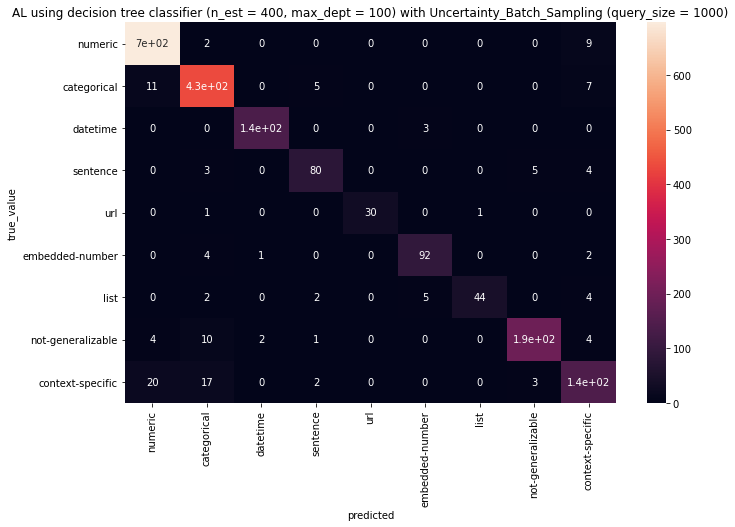

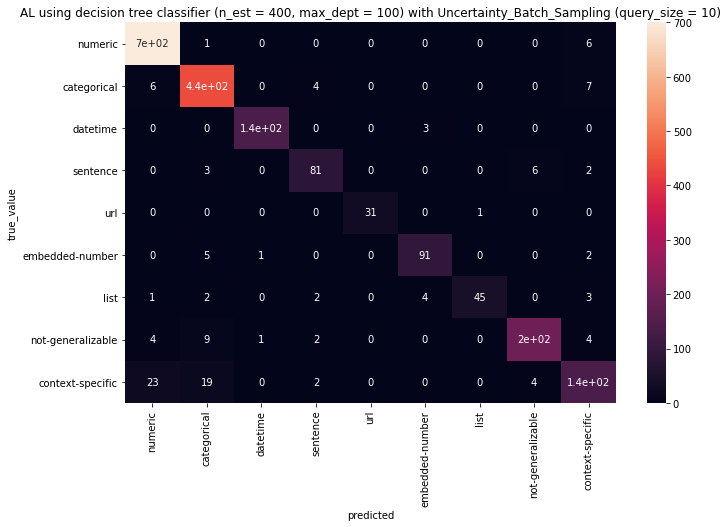

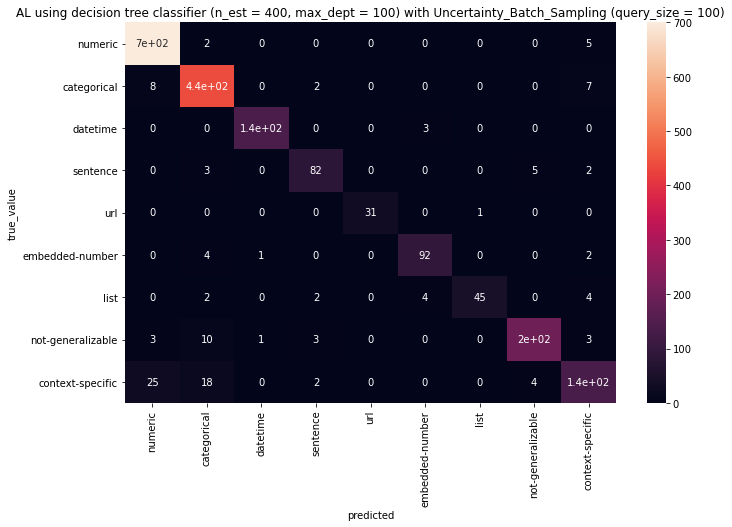

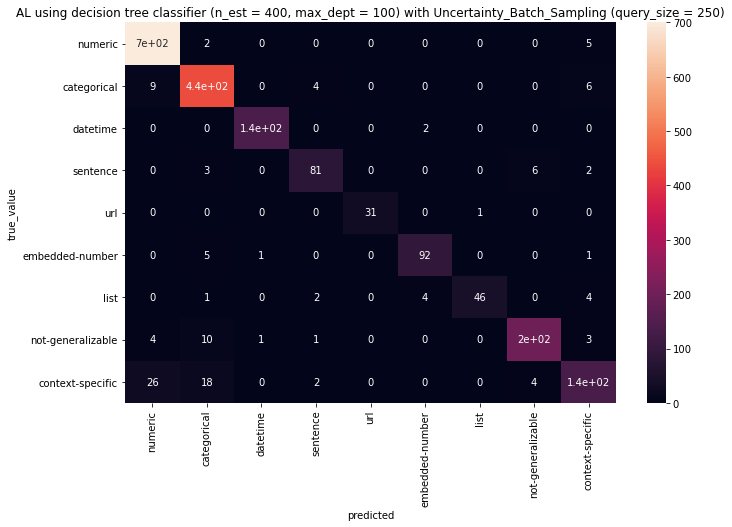

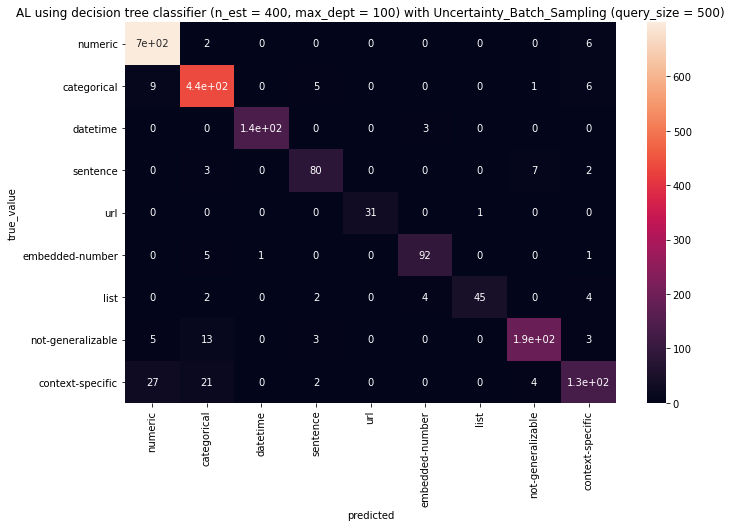

In [14]:
for qs in [1000, 10, 100,250,500]:
    train_this(n_est=400, max_dept=100, query_size=qs, max_feed = 1000)

dict_keys(['filename', 'num_queries', 'time', 'total_time', 'train_accuracy', 'simulation_accuracy', 'test_accuracy'])
dict_keys(['filename', 'num_queries', 'time', 'total_time', 'train_accuracy', 'simulation_accuracy', 'test_accuracy'])
dict_keys(['filename', 'num_queries', 'time', 'total_time', 'train_accuracy', 'simulation_accuracy', 'test_accuracy'])
dict_keys(['filename', 'num_queries', 'time', 'total_time', 'train_accuracy', 'simulation_accuracy', 'test_accuracy'])
dict_keys(['filename', 'num_queries', 'time', 'total_time', 'train_accuracy', 'simulation_accuracy', 'test_accuracy'])
dict_keys(['filename', 'num_queries', 'time', 'total_time', 'train_accuracy', 'simulation_accuracy', 'test_accuracy'])


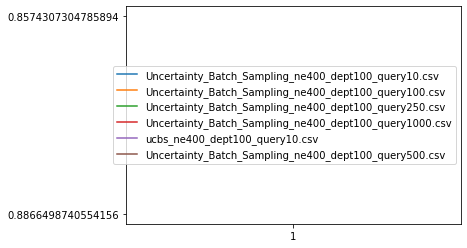

In [15]:
path = "./his"
files = os.listdir(path)

def get_results():
    for f in files:
        if f.endswith(".csv") and not f.startswith("test"):
            with open(f"{path}/{f}", mode='r') as infile:
                reader = csv.reader(infile)
                temp = zip(*reader)

                results = {"filename": f}
                for i in temp:
                    results[i[0]] = i[1:]
                yield results
                
for r in get_results():
    print(r.keys())
    plt.plot(r["num_queries"], r["test_accuracy"], label = r["filename"])
plt.legend()
plt.show()